<h2> Data Preprocessing</h2>

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_matrix = pd.read_csv("LaturRains_1965_2002.csv",sep="\t")
type(data_matrix)

#check if NaN are there
data_matrix.isnull().any().any()

False

In [3]:
data_matrix.set_index('Year', inplace=True)
data_matrix = data_matrix.transpose()
data_matrix.head()

Year,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,...,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002
Jan,0.272,5.439,1.318,2.708,0.000,3.224,0.168,0.000,0.000,0.000,...,0.000,12.229,14.457,0.376,11.575,0.000,0.000,0.000,7.385,10.846
Feb,0.082,1.949,0.705,54.213,0.000,0.000,0.000,0.649,0.092,0.000,...,1.527,6.256,0.000,3.540,0.000,2.786,8.173,6.343,0.000,0.324
Mar,0.000,4.044,3.735,35.990,0.804,0.000,0.660,0.025,0.000,0.424,...,2.011,7.880,22.736,1.496,6.189,0.760,0.000,0.000,28.177,4.526
Apr,2.093,5.869,1.509,3.302,4.353,26.318,1.926,9.806,3.731,5.076,...,5.291,29.439,2.986,20.172,34.975,1.652,2.979,4.299,6.978,22.799
May,0.966,10.855,45.454,8.995,9.161,31.172,31.948,13.941,1.903,10.591,...,5.426,14.410,47.057,5.589,9.236,10.623,67.643,35.362,4.065,26.652


In [4]:
dates = pd.date_range(start='1965-01', freq='MS', periods=len(data_matrix.columns)*12)
dates

DatetimeIndex(['1965-01-01', '1965-02-01', '1965-03-01', '1965-04-01',
               '1965-05-01', '1965-06-01', '1965-07-01', '1965-08-01',
               '1965-09-01', '1965-10-01',
               ...
               '2002-03-01', '2002-04-01', '2002-05-01', '2002-06-01',
               '2002-07-01', '2002-08-01', '2002-09-01', '2002-10-01',
               '2002-11-01', '2002-12-01'],
              dtype='datetime64[ns]', length=456, freq='MS')

In [5]:
rainfall_data_matrix_np = data_matrix.transpose().as_matrix()

shape = rainfall_data_matrix_np.shape
rainfall_data_matrix_np = rainfall_data_matrix_np.reshape((shape[0] * shape[1], 1))

/home/vubuntu/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


/home/vubuntu/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/home/vubuntu/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


pandas.core.frame.DataFrame

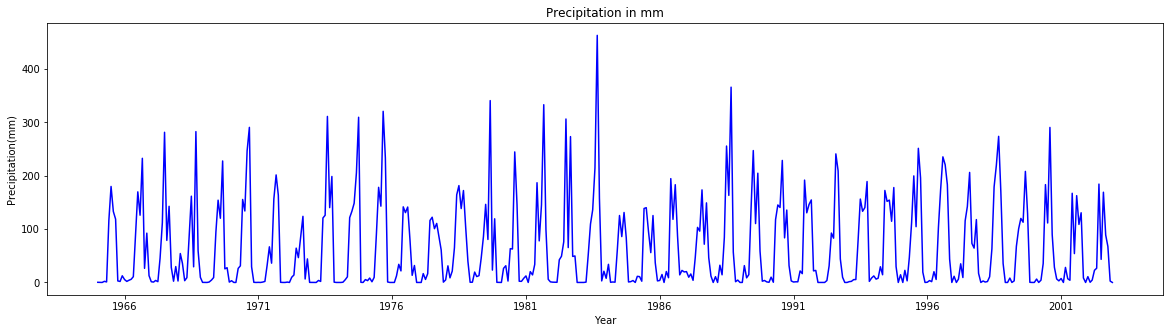

In [6]:
rainfall_data = pd.DataFrame({'Precipitation': rainfall_data_matrix_np[:,0]})
rainfall_data.set_index(dates, inplace=True)

plt.figure(figsize=(20,5))
plt.plot(rainfall_data, color='blue')
plt.xlabel('Year')
plt.ylabel('Precipitation(mm)')
plt.title('Precipitation in mm')
test_data = rainfall_data.ix['1995': '2002']
train_data = rainfall_data.ix[: '1994']
type(train_data)

In [7]:
train_data.tail() # 1965-1994

,Precipitation
1994-08-01,154.409
1994-09-01,114.689
1994-10-01,177.968
1994-11-01,29.630
1994-12-01,0.000


In [8]:
test_data.head() # 1995-2002

,Precipitation
1995-01-01,14.457
1995-02-01,0.000
1995-03-01,22.736
1995-04-01,2.986
1995-05-01,47.057


<h2> Data Plot</h2>

Text(0.5,1,'Precipitation data in mm of Latur from 1965-2002')

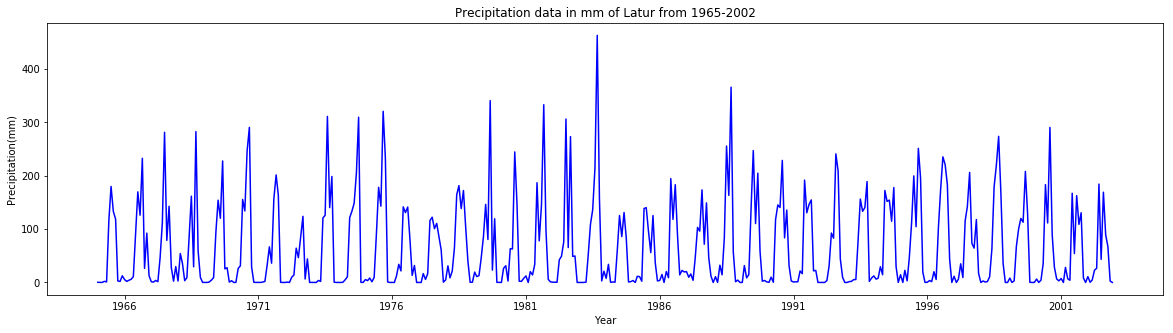

In [9]:
plt.figure(figsize=(20,5))
plt.plot(rainfall_data, color='blue')
plt.xlabel('Year')
plt.ylabel('Precipitation(mm)')
plt.title('Precipitation data in mm of Latur from 1965-2002')

<h2> Building the LSTM Model</h2>

In [10]:
# Let's load the required libs.
# We'll be using the Tensorflow backend (default).
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from keras.callbacks import LambdaCallback


Using TensorFlow backend.


<p> Form the data plot, we clearly observe that there is no trend but seasonality component is present.</p>
<p> Seasonality may be due to the seasonal effects in the climate such as rainy season where more precipitation is expected than in summer or winter.</p>
<p> Unlike in ARIMA where we need to explicity find out the (P,D,Q) values, we don't need to do such ground work while using neural networks such as LSTMs.</p>
<p> We transform the data as follows for the reasons provided below</p>
<ul>
    <li>Normalize the data for increased numerical stability.</li>
    <li>Reshape the data so that we have one column for response varible(Y) and another for the predictor(X).</li>
</ul>

<b> Data Preparation</b>

In [11]:
# Get the raw data values from the pandas data frame.
data_raw = rainfall_data.values.astype("float32")

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(data_raw)

# Print a few values.
dataset[0:5]

array([[0.00058702],
       [0.00017697],
       [0.        ],
       [0.00451701],
       [0.00208477]], dtype=float32)

<b>Split Data into Train and Test datasets</b>

In [28]:
#using 80% of data to train amd 20% to test

TRAIN_SIZE = 0.8
train_size = int(len(dataset)*TRAIN_SIZE)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print dataset.shape
print train.shape
print test.shape
print("Number of entries (training set, test set): " + str((len(train), len(test))))

(456, 1)
(364, 1)
(92, 1)
Number of entries (training set, test set): (364, 92)


In [29]:
def create_dataset(dataset, window_size = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size), 0]
        data_X.append(a)
#         print("--",dataset[i+window_size,0],"--")
        data_Y.append(dataset[i + window_size, 0])
    return(np.array(data_X), np.array(data_Y))

In [60]:
# Create test and training sets for one-step-ahead regression.
window_size = 12
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
print("Original training data shape:")
# print(train_Y)
print(train_X.shape)
print(train_Y.shape)

# Reshape the input data into appropriate form for Keras.
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
train_Y = np.reshape(train_Y, (train_Y.shape[0], 1))
test_Y = np.reshape(test_Y, (test_Y.shape[0], 1))
print("New training data shape:")
print(train_X.shape)
print(train_Y.shape)

Original training data shape:
(351, 12)
(351,)
New training data shape:
(351, 1, 12)
(351, 1)


In [61]:
# train_X[:5]

<b> Build a simple LSTM</b>
<p>The LSTM architecture here consists of:</p>
<ul>
<li>One input layer.</li>
<li>One LSTM layer of 4 blocks.</li>
<li>One Dense layer to produce a single output.</li>
<li>Use MSE as loss function.</li>
</ul>
<p>Many different architectures could be considered. But this is just a quick test, so we'll keep things nice and simple.</p>

In [62]:
def fit_model(train_X,train_Y,window_size=1):
    
    model = Sequential()
    model.add(LSTM(6,input_shape=(1,window_size)))
#     model.add(LSTM(6,input_shape=(1,window_size)))
    model.add(Dense(1))
#     print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: print(model.layers[0].get_weights()))
    model.compile(loss='mean_squared_error',
                 optimizer='adam', metrics=['mape', 'accuracy'])
#     history = model.fit(train_X,train_Y,validation_data=(test_X, test_Y),epochs=250,batch_size=1,callbacks = [print_weights],verbose=2)
    history = model.fit(train_X,train_Y,validation_data=(test_X, test_Y),epochs=250,batch_size=1,verbose=2)
    return model,history

#     on_epoch_end=lambda batch, logs: print (model.layers[1].get_weights())
#fit the model
model1, history = fit_model(train_X, train_Y, window_size)
plot_model(model1, to_file='LSTM_Latur_plot_1.png', show_shapes=True, show_layer_names=True)
model1.summary()

Train on 351 samples, validate on 79 samples
Epoch 1/250
 - 1s - loss: 0.0345 - mean_absolute_percentage_error: 9877082.4549 - acc: 0.1111 - val_loss: 0.0183 - val_mean_absolute_percentage_error: 10004909.9560 - val_acc: 0.1392
Epoch 2/250
 - 1s - loss: 0.0175 - mean_absolute_percentage_error: 5729666.2063 - acc: 0.1111 - val_loss: 0.0117 - val_mean_absolute_percentage_error: 6122528.9487 - val_acc: 0.1392
Epoch 3/250
 - 1s - loss: 0.0151 - mean_absolute_percentage_error: 4460991.8354 - acc: 0.1111 - val_loss: 0.0108 - val_mean_absolute_percentage_error: 4838567.2664 - val_acc: 0.1392
Epoch 4/250
 - 1s - loss: 0.0144 - mean_absolute_percentage_error: 4121967.1273 - acc: 0.1111 - val_loss: 0.0104 - val_mean_absolute_percentage_error: 4039521.1483 - val_acc: 0.1392
Epoch 5/250
 - 1s - loss: 0.0140 - mean_absolute_percentage_error: 3695424.1161 - acc: 0.1111 - val_loss: 0.0100 - val_mean_absolute_percentage_error: 3467446.7642 - val_acc: 0.1392
Epoch 6/250
 - 1s - loss: 0.0136 - mean_abso

Epoch 46/250
 - 1s - loss: 0.0113 - mean_absolute_percentage_error: 1967562.2088 - acc: 0.1111 - val_loss: 0.0090 - val_mean_absolute_percentage_error: 3403238.4616 - val_acc: 0.1392
Epoch 47/250
 - 1s - loss: 0.0114 - mean_absolute_percentage_error: 2315161.1706 - acc: 0.1111 - val_loss: 0.0084 - val_mean_absolute_percentage_error: 2259645.8937 - val_acc: 0.1392
Epoch 48/250
 - 1s - loss: 0.0113 - mean_absolute_percentage_error: 2408799.1634 - acc: 0.1111 - val_loss: 0.0086 - val_mean_absolute_percentage_error: 2327340.8465 - val_acc: 0.1392
Epoch 49/250
 - 1s - loss: 0.0113 - mean_absolute_percentage_error: 2017964.6471 - acc: 0.1111 - val_loss: 0.0086 - val_mean_absolute_percentage_error: 2470175.8254 - val_acc: 0.1392
Epoch 50/250
 - 1s - loss: 0.0113 - mean_absolute_percentage_error: 2228864.5362 - acc: 0.1111 - val_loss: 0.0084 - val_mean_absolute_percentage_error: 2297059.7835 - val_acc: 0.1392
Epoch 51/250
 - 1s - loss: 0.0113 - mean_absolute_percentage_error: 2309044.6324 - ac

Epoch 91/250
 - 1s - loss: 0.0105 - mean_absolute_percentage_error: 1887176.9425 - acc: 0.1111 - val_loss: 0.0081 - val_mean_absolute_percentage_error: 1215539.7906 - val_acc: 0.1392
Epoch 92/250
 - 1s - loss: 0.0105 - mean_absolute_percentage_error: 1703881.2687 - acc: 0.1111 - val_loss: 0.0081 - val_mean_absolute_percentage_error: 1419225.4702 - val_acc: 0.1392
Epoch 93/250
 - 1s - loss: 0.0105 - mean_absolute_percentage_error: 1683504.2908 - acc: 0.1111 - val_loss: 0.0080 - val_mean_absolute_percentage_error: 1937778.7525 - val_acc: 0.1392
Epoch 94/250
 - 1s - loss: 0.0104 - mean_absolute_percentage_error: 2006356.7250 - acc: 0.1111 - val_loss: 0.0082 - val_mean_absolute_percentage_error: 1400454.8895 - val_acc: 0.1392
Epoch 95/250
 - 1s - loss: 0.0104 - mean_absolute_percentage_error: 1642824.0951 - acc: 0.1111 - val_loss: 0.0082 - val_mean_absolute_percentage_error: 1254241.9884 - val_acc: 0.1392
Epoch 96/250
 - 1s - loss: 0.0105 - mean_absolute_percentage_error: 2146746.5111 - ac

Epoch 136/250
 - 1s - loss: 0.0101 - mean_absolute_percentage_error: 1550033.5639 - acc: 0.1111 - val_loss: 0.0083 - val_mean_absolute_percentage_error: 2175382.7102 - val_acc: 0.1392
Epoch 137/250
 - 1s - loss: 0.0100 - mean_absolute_percentage_error: 1785760.4608 - acc: 0.1111 - val_loss: 0.0083 - val_mean_absolute_percentage_error: 1544699.9386 - val_acc: 0.1392
Epoch 138/250
 - 1s - loss: 0.0101 - mean_absolute_percentage_error: 1526516.9136 - acc: 0.1111 - val_loss: 0.0087 - val_mean_absolute_percentage_error: 2036385.6850 - val_acc: 0.1392
Epoch 139/250
 - 1s - loss: 0.0100 - mean_absolute_percentage_error: 1785108.7496 - acc: 0.1111 - val_loss: 0.0083 - val_mean_absolute_percentage_error: 1170096.8354 - val_acc: 0.1392
Epoch 140/250
 - 1s - loss: 0.0100 - mean_absolute_percentage_error: 1722157.7821 - acc: 0.1111 - val_loss: 0.0082 - val_mean_absolute_percentage_error: 1201158.3875 - val_acc: 0.1392
Epoch 141/250
 - 1s - loss: 0.0100 - mean_absolute_percentage_error: 1866170.024

Epoch 181/250
 - 1s - loss: 0.0097 - mean_absolute_percentage_error: 1647963.3938 - acc: 0.1111 - val_loss: 0.0092 - val_mean_absolute_percentage_error: 3293541.7514 - val_acc: 0.1392
Epoch 182/250
 - 1s - loss: 0.0098 - mean_absolute_percentage_error: 1706496.5325 - acc: 0.1111 - val_loss: 0.0083 - val_mean_absolute_percentage_error: 1325802.5961 - val_acc: 0.1392
Epoch 183/250
 - 1s - loss: 0.0096 - mean_absolute_percentage_error: 1575401.2123 - acc: 0.1111 - val_loss: 0.0084 - val_mean_absolute_percentage_error: 1830508.1036 - val_acc: 0.1392
Epoch 184/250
 - 1s - loss: 0.0097 - mean_absolute_percentage_error: 1387216.2586 - acc: 0.1111 - val_loss: 0.0082 - val_mean_absolute_percentage_error: 1834199.8115 - val_acc: 0.1392
Epoch 185/250
 - 1s - loss: 0.0097 - mean_absolute_percentage_error: 1735199.9161 - acc: 0.1111 - val_loss: 0.0086 - val_mean_absolute_percentage_error: 2415826.2386 - val_acc: 0.1392
Epoch 186/250
 - 1s - loss: 0.0097 - mean_absolute_percentage_error: 1761328.280

Epoch 226/250
 - 1s - loss: 0.0093 - mean_absolute_percentage_error: 1968322.7059 - acc: 0.1111 - val_loss: 0.0095 - val_mean_absolute_percentage_error: 3445774.1130 - val_acc: 0.1392
Epoch 227/250
 - 1s - loss: 0.0094 - mean_absolute_percentage_error: 1738445.9723 - acc: 0.1111 - val_loss: 0.0083 - val_mean_absolute_percentage_error: 2233469.2993 - val_acc: 0.1392
Epoch 228/250
 - 1s - loss: 0.0094 - mean_absolute_percentage_error: 1843828.9645 - acc: 0.1111 - val_loss: 0.0084 - val_mean_absolute_percentage_error: 1755089.8408 - val_acc: 0.1392
Epoch 229/250
 - 1s - loss: 0.0093 - mean_absolute_percentage_error: 1917098.5890 - acc: 0.1111 - val_loss: 0.0086 - val_mean_absolute_percentage_error: 2370604.5248 - val_acc: 0.1392
Epoch 230/250
 - 1s - loss: 0.0093 - mean_absolute_percentage_error: 1689470.9765 - acc: 0.1111 - val_loss: 0.0085 - val_mean_absolute_percentage_error: 2357646.1123 - val_acc: 0.1392
Epoch 231/250
 - 1s - loss: 0.0094 - mean_absolute_percentage_error: 1768687.618


<h2>Results</h2>

<b>Predictions and model evaluation</b>

In [56]:
train_Y.shape

(357, 1)

In [57]:
test_Y.shape

(85, 1)

In [58]:
def predict_and_score(model,X,Y):
    #Make predictions on the original scale of data
    pred = scaler.inverse_transform(model.predict(X))
    #Prepare Y also to be in original data scale
    orig_data = scaler.inverse_transform(Y)
#     print(orig_data)
#     print("-----")
#     print(pred[:,0])
    #Calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred[:, 0]))
    return (score,pred)

train_rmse, train_predict = predict_and_score(model1, train_X, train_Y)
test_rmse, test_predict = predict_and_score(model1, test_X, test_Y)

# train_rmse, train_predict = predict_and_score(model1, train_X, np.reshape(train_Y, (train_Y.shape[0], 1,1)))
# test_rmse, test_predict = predict_and_score(model1, test_X, np.reshape(test_Y, (test_Y.shape[0],1, 1)))

print("Training data score: %.2f RMSE" % train_rmse)
print("Test data score: %.2f RMSE" % test_rmse)



Training data score: 50.81 RMSE
Test data score: 41.26 RMSE


In [59]:
# start with training predictions
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:,:] = np.nan
train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict

# Add test predictions.
test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

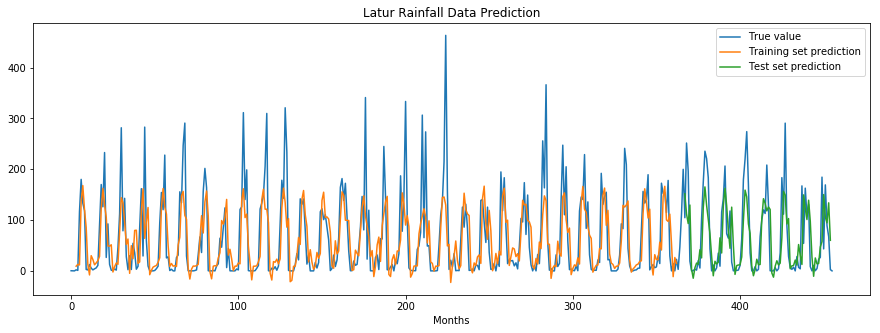

In [49]:
# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(dataset), label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("Months")
plt.ylabel("")
plt.title("Latur Rainfall Data Prediction")
plt.legend()
plt.show()

['acc', 'loss', 'val_mean_absolute_percentage_error', 'mean_absolute_percentage_error', 'val_acc', 'val_loss']


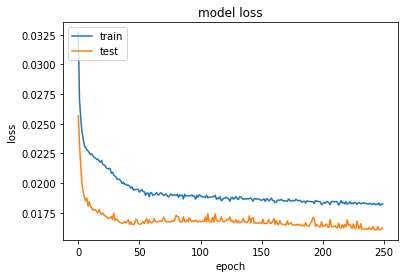

In [50]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()



# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [51]:
print("Training data score: %.2f RMSE" % train_rmse)
print("Test data score: %.2f RMSE" % test_rmse)

Training data score: 62.29 RMSE
Test data score: 58.98 RMSE


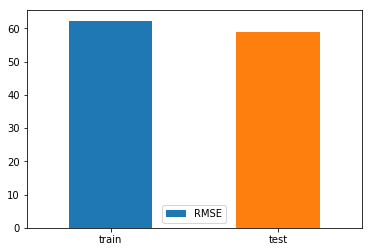

In [55]:
plot_df = pd.DataFrame({'':['train','test'], 'RMSE':[,test_rmse]})
ax = plot_df.plot.bar(x='', y='RMSE', rot=0)